In [ ]:
import torch
from torch import nn
from torch import optim
import os
import torch.nn.functional as F
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.6-cp36-cp36m-linux_x86_64.whl
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
import torchvision
from torchvision import datasets, transforms
import sys
import math

import shutil
!pip install setproctitle
import setproctitle

# !pip install import-ipynb
# import import_ipynb

# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/My\ Drive
# !ls

# import densenet_torch
# import make_graph


In [ ]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
!pip install import-ipynb
import import_ipynb

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive
!ls

class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 100

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
'?????????????? ?? ???????????????????? ???????? ?????????????????? ?????????????? ???????????? 2.pdf'
 Ali_Eshtehardian_CV.pdf
 cifar
'Colab Notebooks'
'Copy of img_align_celeba.zip'
 C-VAE2.ipynb
 C-VAE.ipynb
 DAE.ipynb
 data
 Data_train_input.xlsx
 Data_train_output.xlsx
 densenet.ipynb
 densenet_torch.ipynb
 FTM.gdoc
 FTM.pdf
 GAN.ipynb
 grammarly_account.jpg
 img_align_celeba2
 img_align_celeba.zip
 indices_train_test.mat
 make_graph.ipynb
 mnist_data
'MNIST_LSTM(32).pt'
 models_64x64.ipynb
 ops2.ipynb
 pytorch-xla-env-setup.py
 scan0001.pdf
 shakespeare_LSTM.pt
 shakespeare.txt
 test_index.npy
 testnet.ipynb
 torch-nightly+20200516-cp36-cp36m-linux_x86_64.whl
 torch-nightly-cp36-cp36m-linux_x86_64.whl
 torchvision-nightly+20200516-cp36-cp36m-linux_x86_64.whl
 torchvision-nightly-cp36-cp36m-linux_x86_64.whl
 torch_xla-nightly+2020

In [ ]:
class SiameseNetworkDataset(Dataset):

    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found

                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [ ]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

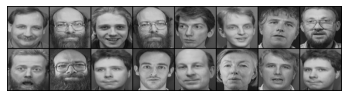

[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]]


In [ ]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(Bottleneck, self).__init__()
        interChannels = 4*growthRate
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, interChannels, kernel_size=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(interChannels)
        self.conv2 = nn.Conv2d(interChannels, growthRate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat((x, out), 1)
        return out

In [ ]:
class SingleLayer(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(SingleLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, growthRate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = torch.cat((x, out), 1)
        return out

In [ ]:
class Transition(nn.Module):
    def __init__(self, nChannels, nOutChannels):
        super(Transition, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, nOutChannels, kernel_size=1,
                               bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = F.avg_pool2d(out, 2)
        return out

In [ ]:
# class DenseNet(nn.Module):
#     def __init__(self, growthRate, nDenseBlocks, reduction, nClasses, bottleneck):
#         super(DenseNet, self).__init__()

#         # nDenseBlocks = (depth-4) // 3
#         if bottleneck:
#             nDenseBlocks //= 2

#         nChannels = 2*growthRate
#         self.conv1 = nn.Conv2d(3, nChannels, kernel_size=3, padding=1,
#                                bias=False)
#         self.dense1 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
#         nChannels += nDenseBlocks*growthRate
#         nOutChannels = int(math.floor(nChannels*reduction))
#         self.trans1 = Transition(nChannels, nOutChannels)

#         nChannels = nOutChannels
#         self.dense2 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
#         nChannels += nDenseBlocks*growthRate
#         nOutChannels = int(math.floor(nChannels*reduction))
#         self.trans2 = Transition(nChannels, nOutChannels)

#         nChannels = nOutChannels
#         self.dense3 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
#         nChannels += nDenseBlocks*growthRate

#         self.bn1 = nn.BatchNorm2d(nChannels)
#         self.fc = nn.Linear(nChannels, nClasses)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                 m.weight.data.normal_(0, math.sqrt(2. / n))
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(1)
#                 m.bias.data.zero_()
#             elif isinstance(m, nn.Linear):
#                 m.bias.data.zero_()

#     def _make_dense(self, nChannels, growthRate, nDenseBlocks, bottleneck):
#         layers = []
#         for i in range(int(nDenseBlocks)):
#             if bottleneck:
#                 layers.append(Bottleneck(nChannels, growthRate))
#             else:
#                 layers.append(SingleLayer(nChannels, growthRate))
#             nChannels += growthRate
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = self.conv1(x)
#         out = self.trans1(self.dense1(out))
#         out = self.trans2(self.dense2(out))
#         out = self.dense3(out)
#         out = torch.squeeze(F.avg_pool2d(F.relu(self.bn1(out)), 8))
#         out = F.log_softmax(self.fc(out))
#         return out

In [ ]:
def make_dense(nChannels, growthRate, nDenseBlocks, bottleneck):
        layers = []
        for i in range(int(nDenseBlocks)):
            if bottleneck:
                layers.append(Bottleneck(nChannels, growthRate))
            else:
                layers.append(SingleLayer(nChannels, growthRate))
            nChannels += growthRate
        return nn.Sequential(*layers)

In [ ]:
class CFFN(nn.Module):
    def __init__(self):
        super(CFFN, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            # nn.ReflectionPad2d(1),
            # nn.Conv2d(4, 8, kernel_size=3),
            # nn.ReLU(inplace=True),
            # nn.BatchNorm2d(8),


            # nn.ReflectionPad2d(1),
            # nn.Conv2d(8, 8, kernel_size=3),
            # nn.ReLU(inplace=True),
            # nn.BatchNorm2d(8),


        )
        # self.dense1=make_dense(nChannels=8, growthRate=24, nDenseBlocks=2,bottleneck=True)

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        # output = self.dense1(output)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

  # def __init__(self):
  #   super(CFFN,self).__init__()

    # self.conv1 = nn.Conv2d(1, 8, kernel_size=7)
    # self.dense1=DenseNet(growthRate=24, nDenseBlocks=2, reduction=0.5,
    #                         bottleneck=True, nClasses=48)
    # self.dense2=DenseNet(growthRate=24, nDenseBlocks=3, reduction=0.5,
    #                         bottleneck=True, nClasses=60)
    # self.dense3=DenseNet(growthRate=24, nDenseBlocks=4, reduction=0.5,
    #                         bottleneck=True, nClasses=78)
    # self.dense4=DenseNet(growthRate=24, nDenseBlocks=2, reduction=0.5,
    #                         bottleneck=True, nClasses=126)
    # self.conv2= nn.Conv2d(126, 128, kernel_size=3)

    # self.fc1=nn.Linear(8*98*98,384)
    # self.conv3=nn.Conv2d(128,2,3)
    # self.pool=nn.AvgPool2d(2,2)
    # self.fc2=nn.Linear(2,1)

  # def forward_once(self, x):
    # x1=F.relu(self.conv1(x))
    # x2=self.dense2(self.dense1(x1))
    # x3=self.dense3(x2)
    # x4=self.dense4(x3)
    # x5=F.relu(self.conv2(x4))
    # x6=torch.cat((x5,x4,x3),0)
    # x1 = x1.view(-1, 8*98*98)
    # output=self.fc1(x1)
    # x8=F.relu(self.conv2(x6))
    # x9=self.pool(x8)
    # output=F.softmax(self.fc2(x9))
    # return output
  # def forward(self, input1, input2):
  #       output1 = self.forward_once(input1)
  #       output2 = self.forward_once(input2)
  #       return output1, output2

In [ ]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:
net = CFFN().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005)

In [ ]:
counter = []
loss_history = []
iteration_number= 0

In [ ]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        print(img0.shape)
        print(img1.shape)
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

In [ ]:
# cffn=CFFN()
# criterion = ContrastiveLoss()
# optimizer = optim.SGD(cffn.parameters(), lr=0.001, momentum=0.9)

# # net = SiameseNetwork().cuda()
# # criterion = ContrastiveLoss()
# # optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

# counter = []
# loss_history = []
# iteration_number= 0

# for epoch in range(100):
#     for i, data in enumerate(trainloader,0):
#         img0, img1 , label = data
#         img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
#         output1,output2 = net(img0,img1)
#         optimizer.zero_grad()
#         loss_contrastive = criterion(output1,output2,label)
#         loss_contrastive.backward()
#         optimizer.step()
#         if i %10 == 0 :
#             print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data[0]))
#             iteration_number +=10
#             counter.append(iteration_number)
#             loss_history.append(loss_contrastive.data[0])
# show_plot(counter,loss_history)